**Projeto: Previsão de Vendas para Otimização de Estoque**

**Objetivo:** Prever as quantidades de itens vendidos por categoria de produto, utilizando dados históricos de pedidos realizados em um e-commerce brasileiro. A previsão ajudará na tomada de decisões estratégicas para otimizar estoques, garantindo que categorias com maior demanda tenham disponibilidade suficiente e reduzindo a possibilidade de rupturas, especialmente em lojas que operam em plataformas de marketplace.

**Base de Dados: Brazilian E-Commerce Public Dataset by Olist**  
**Fonte:** [Kaggle - Brazilian E-Commerce Public Dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

**Sobre o dataset:** O dataset contém aproximadamente 100 mil registros de pedidos realizados entre 2016 e 2018 em marketplaces brasileiros. Ele oferece uma visão detalhada dos pedidos sob diversas perspectivas, como status do pedido, preços, formas de pagamento, desempenho logístico, localização dos clientes, características dos produtos e avaliações dos consumidores. Apesar de os dados serem reais, informações sensíveis foram anonimizadas, e referências específicas a empresas e parceiros foram substituídas por dados genéricos.

Para este projeto, focaremos em cinco dos nove conjuntos de dados disponíveis, priorizando informações essenciais para prever as quantidades vendidas por categoria. Os conjuntos selecionados são:  

- **items**: Detalhes dos itens nos pedidos.  
- **orders**: Informações gerais dos pedidos.  
- **products**: Especificações dos produtos.  
- **customers**: Dados sobre os clientes.  
- **review**: Avaliações feitas pelos consumidores.  

A seleção desses conjuntos visa concentrar a análise em dados diretamente relacionados aos itens vendidos e suas categorias. Com isso, será possível construir um modelo preditivo robusto, alinhado ao objetivo principal de antecipar demandas e otimizar a gestão de estoques.


### Bibliotecas

In [3]:
# Importação dos Dados
import os

# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos e Pré-processamento
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# Algoritmos e utilidades adicionais
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from mlxtend.preprocessing import TransactionEncoder

# Visualização de Modelos
from yellowbrick.regressor import residuals_plot, prediction_error


### UPLOAD DOS ARQUIVOS

In [5]:
# Configurar diretório para armazenamento dos dados
data_dir = "./olist_data"
os.makedirs(data_dir, exist_ok=True)

# Baixar dados do Kaggle
!kaggle datasets download -d olistbr/brazilian-ecommerce -p {data_dir} --unzip

# Dicionário com os nomes dos arquivos
files = {
    'items': f'{data_dir}/olist_order_items_dataset.csv',
    'orders': f'{data_dir}/olist_orders_dataset.csv',
    'products': f'{data_dir}/olist_products_dataset.csv',
    'customers': f'{data_dir}/olist_customers_dataset.csv',
    'review': f'{data_dir}/olist_order_reviews_dataset.csv'
}

# Carregar os arquivos CSV em um dicionário de DataFrames
df = {key: pd.read_csv(value) for key, value in files.items()}

# Verificar se os dados foram carregados corretamente
for key, dataframe in df.items():
    print(f"\n=== DataFrame '{key}' ===")
    print(f"Dimensões: {dataframe.shape}")
    print(dataframe.head(), "\n")


Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0




  0%|          | 0.00/42.6M [00:00<?, ?B/s]
  2%|2         | 1.00M/42.6M [00:00<00:33, 1.31MB/s]
  5%|4         | 2.00M/42.6M [00:00<00:17, 2.41MB/s]
  7%|7         | 3.00M/42.6M [00:01<00:12, 3.25MB/s]
  9%|9         | 4.00M/42.6M [00:01<00:10, 3.96MB/s]
 12%|#1        | 5.00M/42.6M [00:01<00:08, 4.44MB/s]
 14%|#4        | 6.00M/42.6M [00:01<00:08, 4.80MB/s]
 16%|#6        | 7.00M/42.6M [00:01<00:07, 5.09MB/s]
 19%|#8        | 8.00M/42.6M [00:02<00:06, 5.35MB/s]
 21%|##1       | 9.00M/42.6M [00:02<00:06, 5.47MB/s]
 23%|##3       | 10.0M/42.6M [00:02<00:06, 5.41MB/s]
 26%|##5       | 11.0M/42.6M [00:02<00:05, 5.58MB/s]
 28%|##8       | 12.0M/42.6M [00:02<00:05, 5.80MB/s]
 30%|###       | 13.0M/42.6M [00:02<00:05, 5.81MB/s]
 33%|###2      | 14.0M/42.6M [00:03<00:05, 5.94MB/s]
 35%|###5      | 15.0M/42.6M [00:03<00:04, 6.05MB/s]
 38%|###7      | 16.0M/42.6M [00:03<00:04, 6.10MB/s]
 40%|###9      | 17.0M/42.6M [00:03<00:04, 6.07MB/s]
 42%|####2     | 18.0M/42.6M [00:03<00:04, 5.93MB/s]
 


=== DataFrame 'items' ===
Dimensões: (112650, 7)
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17

### **Projeto: Previsão de Vendas para Otimização de Estoque**

 **Etapa: Carregamento dos Dados do Kaggle**

Nesta parte do projeto, precisei carregar os dados, mas como eles são grandes e seria inviável armazená-los no GitHub, optei por usar a API do Kaggle para fazer o download diretamente. Isso facilita muito o processo e também deixa o projeto mais organizado e reprodutível. Vou explicar como configurei essa etapa:

**1. Configuração do Ambiente**
Primeiro, usei a biblioteca `os` para criar um diretório chamado `olist_data`. Esse diretório será onde todos os arquivos baixados do Kaggle ficarão salvos. Para garantir que ele existisse, incluí um comando para criá-lo, caso ainda não estivesse lá.

**2. Download dos Dados**
Depois, configurei o código para usar o comando da API do Kaggle. Para isso, utilizei o identificador do dataset, que no caso é `olistbr/brazilian-ecommerce`. Assim, os arquivos foram baixados e extraídos automaticamente no diretório que configurei.

**3. Organização dos Arquivos**
Organizei os nomes dos arquivos em um dicionário, relacionando cada arquivo CSV a uma chave intuitiva, como `items`, `orders` e `products`. Isso deixou o código mais claro e fácil de trabalhar.

**4. Leitura e Validação dos Dados**
Usei o pandas para carregar cada arquivo CSV em um DataFrame e, para garantir que os dados foram carregados corretamente, exibi as dimensões de cada DataFrame (`shape`) e os primeiros registros (`head()`). Isso me deu uma visão geral dos dados logo de início.

**Por que escolhi esse método?**
1. **Reprodutibilidade:** Agora qualquer pessoa que acessar este projeto pode executar o código sem precisar fazer o upload manual dos arquivos.
2. **Automatização:** Todo o processo de download e leitura está integrado, o que economiza tempo e evita erros.
3. **Escalabilidade:** Se no futuro eu precisar adicionar mais arquivos, o código já está pronto para lidar com isso.

### Tratamento dos dados

In [8]:
merged = (
    df['orders']
    .merge(df['items'], on='order_id', how='inner')
    .merge(df['products'], on='product_id', how='inner')
    .merge(df['customers'], on='customer_id', how='inner')
    .merge(df['review'], on='order_id', how='left')
)


In [9]:
merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,...,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,...,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,87285b34884572647811a353c7ac498a,...,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1bafb430e498b939f258b9c9dbdff9b1,3.0,NaN,NaN,2017-11-08 00:00:00,2017-11-10 19:52:38
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50


In [10]:
# Verificando a quantidade de dados duplicados após o cruzamento das bases
merged.duplicated().sum()

0

In [11]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113314 entries, 0 to 113313
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113314 non-null  object 
 1   customer_id                    113314 non-null  object 
 2   order_status                   113314 non-null  object 
 3   order_purchase_timestamp       113314 non-null  object 
 4   order_approved_at              113299 non-null  object 
 5   order_delivered_carrier_date   112111 non-null  object 
 6   order_delivered_customer_date  110839 non-null  object 
 7   order_estimated_delivery_date  113314 non-null  object 
 8   order_item_id                  113314 non-null  int64  
 9   product_id                     113314 non-null  object 
 10  seller_id                      113314 non-null  object 
 11  shipping_limit_date            113314 non-null  object 
 12  price                         

In [12]:
# Convertendo as colunas de data para o formato datetime64
date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date', 
    'shipping_limit_date'
]

merged[date_columns] = merged[date_columns].apply(pd.to_datetime)


In [13]:
# Alterando apenas o campo order_purchase_timestamp para date
merged['order_purchase_timestamp'] = merged['order_purchase_timestamp'].dt.date

In [14]:
# Renomeando a coluna order_item_id
merged.rename(columns={'order_item_id': 'qtd_item'}, inplace = True)

In [15]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113314 entries, 0 to 113313
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113314 non-null  object        
 1   customer_id                    113314 non-null  object        
 2   order_status                   113314 non-null  object        
 3   order_purchase_timestamp       113314 non-null  object        
 4   order_approved_at              113299 non-null  datetime64[ns]
 5   order_delivered_carrier_date   112111 non-null  datetime64[ns]
 6   order_delivered_customer_date  110839 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113314 non-null  datetime64[ns]
 8   qtd_item                       113314 non-null  int64         
 9   product_id                     113314 non-null  object        
 10  seller_id                      113314 non-null  object        
 11  

### **Transformação dos Dados de Data**

Nesta etapa, converti as colunas de data que estavam como objetos para o formato adequado de `datetime64`. Isso facilita as análises temporais, como calcular a diferença entre datas e fazer comparações entre os eventos.

As colunas que foram convertidas incluem:
- `order_purchase_timestamp`
- `order_approved_at`
- `order_delivered_carrier_date`
- `order_delivered_customer_date`
- `order_estimated_delivery_date`
- `shipping_limit_date`

Além disso, ao dar uma olhada no DataFrame, percebi que algumas colunas possuem valores ausentes, o que será algo que vou precisar tratar nas próximas etapas. A conversão das datas ajudou a garantir que as análises temporais sejam feitas da forma correta, sem erros de tipo de dado.


## Análise dos dados

In [18]:
# Top 10 de pedidos por categoria do produto (quantidade)
products = merged.groupby('product_category_name')['qtd_item'].count().reset_index()
products.sort_values(ascending=False, by="qtd_item")[:10].reset_index()

,index,product_category_name,qtd_item
0,13,cama_mesa_banho,11270
1,11,beleza_saude,9727
2,32,esporte_lazer,8700
3,54,moveis_decoracao,8415
4,44,informatica_acessorios,7894
5,72,utilidades_domesticas,6989
6,66,relogios_presentes,6001
7,70,telefonia,4550
8,40,ferramentas_jardim,4361
9,8,automotivo,4256


C:\Users\luan\AppData\Local\Temp\ipykernel_12632\3296551690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='qtd_item', y='product_category_name', data=top_categories_quantity_sorted, palette='viridis')


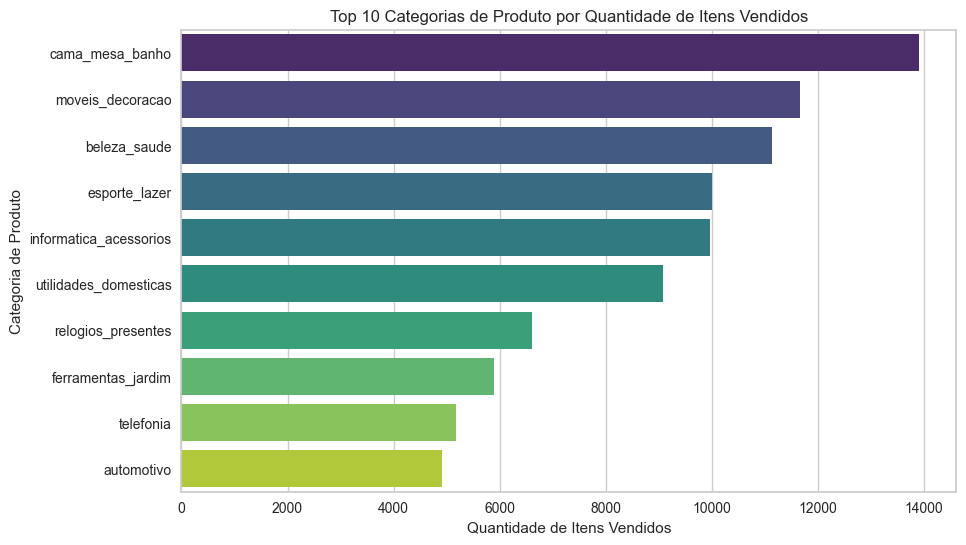

In [19]:
# Agrupando por categoria e contando a quantidade de itens vendidos
top_categories_quantity = merged.groupby('product_category_name')['qtd_item'].sum().reset_index()

# Ordenando em ordem decrescente de quantidade
top_categories_quantity_sorted = top_categories_quantity.sort_values(ascending=False, by="qtd_item").head(10)

# Plotando gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='qtd_item', y='product_category_name', data=top_categories_quantity_sorted, palette='viridis')
plt.title('Top 10 Categorias de Produto por Quantidade de Itens Vendidos')
plt.xlabel('Quantidade de Itens Vendidos')
plt.ylabel('Categoria de Produto')
plt.show()


### **Top 10 de Pedidos por Categoria de Produto**

Realizei uma análise para identificar as 10 categorias de produtos com o maior número de itens vendidos. Para isso, agrupei os dados pela categoria de produto e contei a quantidade de itens vendidos em cada uma.

**Conclusões:**
- As categorias mais vendidas foram: **Cama, Mesa e Banho**, **Beleza e Saúde**, e **Esporte e Lazer**.
- A categoria **Cama, Mesa e Banho** lidera com 11.270 itens vendidos, seguida por **Beleza e Saúde** (9.727 itens).
- As categorias **Automotivo** e **Ferramentas e Jardim** estão entre as menos vendidas, com menos de 5.000 itens.

Essa análise pode ajudar a direcionar a estratégia de estoque e vendas, garantindo que as categorias mais demandadas tenham maior disponibilidade.


In [21]:
# Top 10 de pedidos por categoria do produto (preço)
products_price = merged.groupby(['product_category_name']).agg({"price":"sum", "qtd_item":"count"})
products_price.sort_values(ascending=False, by="price")[:10].reset_index()

,product_category_name,price,qtd_item
0,beleza_saude,1263138.54,9727
1,relogios_presentes,1206075.33,6001
2,cama_mesa_banho,1050936.61,11270
3,esporte_lazer,993656.51,8700
4,informatica_acessorios,919640.54,7894
5,moveis_decoracao,736282.47,8415
6,cool_stuff,637258.51,3806
7,utilidades_domesticas,634542.60,6989
8,automotivo,594363.10,4256
9,ferramentas_jardim,486432.45,4361


C:\Users\luan\AppData\Local\Temp\ipykernel_12632\4262793757.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='revenue', y='product_category_name', data=top_categories_revenue_sorted, palette='magma')


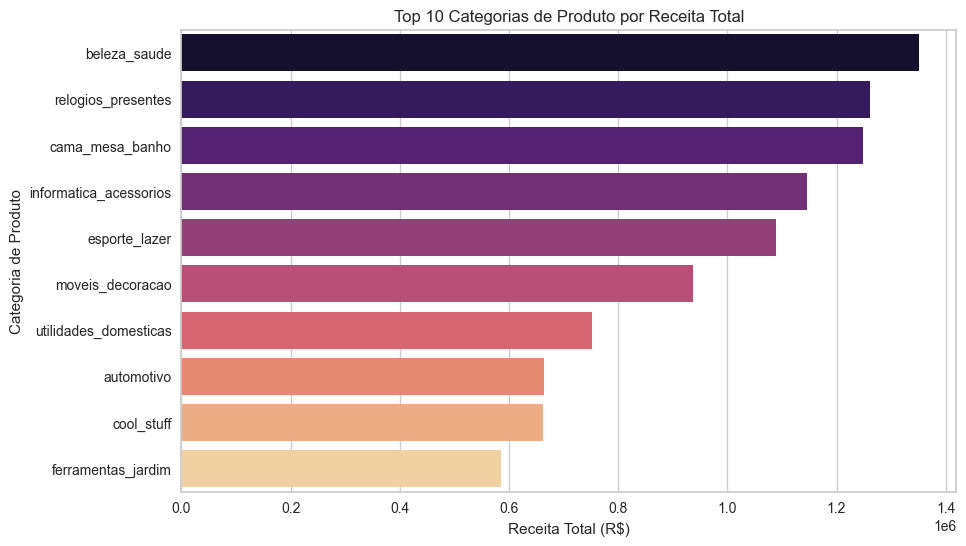

In [22]:
# Agrupando por categoria e somando o preço total (quantidade * preço)
top_categories_revenue = merged.groupby('product_category_name').apply(
    lambda x: (x['price'] * x['qtd_item']).sum()).reset_index(name='revenue')

# Ordenando em ordem decrescente de receita
top_categories_revenue_sorted = top_categories_revenue.sort_values(ascending=False, by='revenue').head(10)

# Plotando gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='revenue', y='product_category_name', data=top_categories_revenue_sorted, palette='magma')
plt.title('Top 10 Categorias de Produto por Receita Total')
plt.xlabel('Receita Total (R$)')
plt.ylabel('Categoria de Produto')
plt.show()


### **Top 10 de Pedidos por Categoria de Produto (Valor Total)**

Nessa análise, calculei o valor total das vendas por categoria de produto, multiplicando a quantidade de itens vendidos pelo preço de cada produto. O objetivo é identificar quais categorias geraram mais receita.

**Conclusões:**
- **Beleza e Saúde** lidera com a maior receita total de R$ 1.263.138,54

- **Relógios e Presentes** (R$ 1.206.075,33)

- **Cama, Mesa e Banho** também aparece entre as três principais, com R$ 1.050.936,61 em vendas

- **Ferramentas e Jardim** e **Automotivo** estão entre as categorias que geraram menos receita, com valores abaixo de R$ 600.000,00.

Essas informações ajudam a identificar as categorias mais lucrativas e podem orientar decisões estratégicas, como promoções e gerenciamento de estoque, focando nas áreas com maior retorno financeiro.


In [24]:
# Top 10 de vendas por Estado (quantidade)
vendas_estado = merged.groupby(["customer_state"]).agg({"price":"sum", "qtd_item":"count"})
vendas_estado.sort_values(ascending=False, by="qtd_item")[:10].reset_index()

,customer_state,price,qtd_item
0,SP,5228869.17,47720
1,RJ,1831678.85,14668
2,MG,1591518.47,13209
3,RS,754250.33,6287
4,PR,685911.51,5764
5,SC,522120.11,4191
6,BA,513182.78,3819
7,DF,304658.17,2433
8,GO,297535.49,2353
9,ES,275910.68,2269


C:\Users\luan\AppData\Local\Temp\ipykernel_12632\2804525903.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_revenue', y='customer_state', data=state_sales_sorted, palette='Blues')


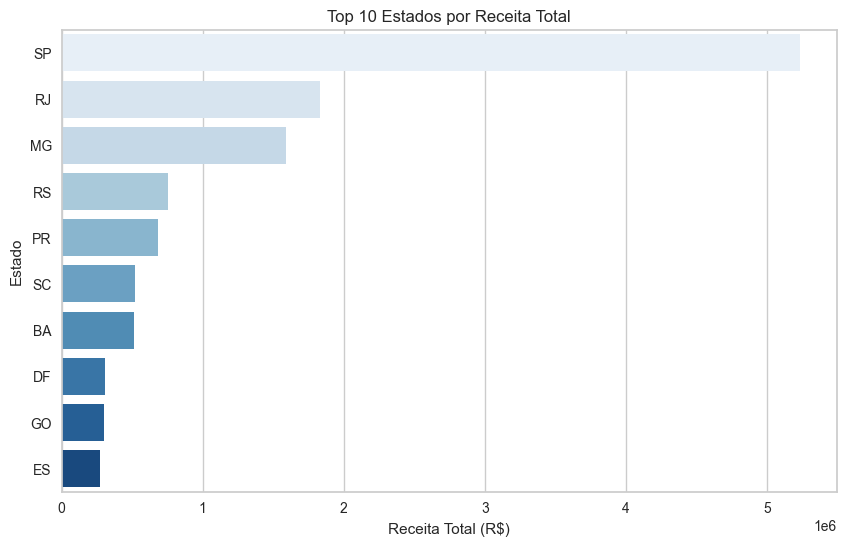

C:\Users\luan\AppData\Local\Temp\ipykernel_12632\2804525903.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_quantity', y='customer_state', data=state_sales_sorted, palette='Greens')


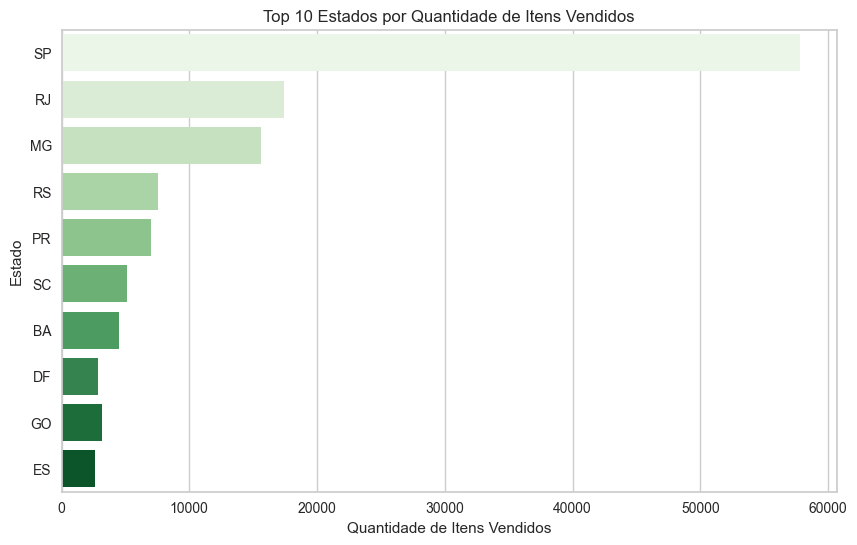

In [25]:
# Agrupando por estado e somando a quantidade e a receita
state_sales = merged.groupby('customer_state').agg(
    total_revenue=('price', 'sum'),
    total_quantity=('qtd_item', 'sum')).reset_index()

# Ordenando por maior receita
state_sales_sorted = state_sales.sort_values(ascending=False, by='total_revenue').head(10)

# Plotando gráfico de barras para receita
plt.figure(figsize=(10, 6))
sns.barplot(x='total_revenue', y='customer_state', data=state_sales_sorted, palette='Blues')
plt.title('Top 10 Estados por Receita Total')
plt.xlabel('Receita Total (R$)')
plt.ylabel('Estado')
plt.show()

# Plotando gráfico de barras para quantidade
plt.figure(figsize=(10, 6))
sns.barplot(x='total_quantity', y='customer_state', data=state_sales_sorted, palette='Greens')
plt.title('Top 10 Estados por Quantidade de Itens Vendidos')
plt.xlabel('Quantidade de Itens Vendidos')
plt.ylabel('Estado')
plt.show()


### **Top 10 de Pedidos por Estado (Valor Total e Quantidade de Itens)**

Nesta análise, calculei a receita total e a quantidade de itens vendidos por estado. O objetivo foi identificar quais estados contribuíram mais para as vendas, tanto em termos de volume quanto de receita gerada.

**Conclusões:**
- **São Paulo (SP)** é o líder absoluto, com uma receita total de R$ 5.228.869,17 e 47.720 itens vendidos.

- **Rio de Janeiro (RJ)** ocupa a segunda com receita de R$ 1.831.678,85

- **Minas Gerais (MG)**  e a terceira posição fica, c/  R$ 1.591.518,47.

- Estados como **Espírito Santo (ES)** e **Goiás (GO)** geraram as menores receitas, com valores abaixo de R$ 300.000,00.

Esses dados podem ajudar a direcionar estratégias de marketing e vendas específicas para cada estado, otimizando o estoque e oferecendo promoções baseadas na demanda regional.


In [27]:
# Top 10 de vendas por Cidade (quantidade)
vendas_cidade = merged.groupby(["customer_state", "customer_city"]).agg({"price":"sum", "qtd_item":"count"})
vendas_cidade.sort_values(ascending=False, by="qtd_item")[:10].reset_index()

,customer_state,customer_city,price,qtd_item
0,SP,sao paulo,1925985.54,17933
1,RJ,rio de janeiro,997535.38,7887
2,MG,belo horizonte,357398.65,3171
3,DF,brasilia,303974.48,2419
4,PR,curitiba,212276.64,1758
5,SP,campinas,189522.28,1661
6,RS,porto alegre,191793.92,1625
7,BA,salvador,181874.19,1422
8,SP,guarulhos,144516.85,1332
9,SP,sao bernardo do campo,104867.95,1069


C:\Users\luan\AppData\Local\Temp\ipykernel_12632\2719456111.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_revenue', y='customer_city', data=city_sales_sorted, palette='coolwarm')


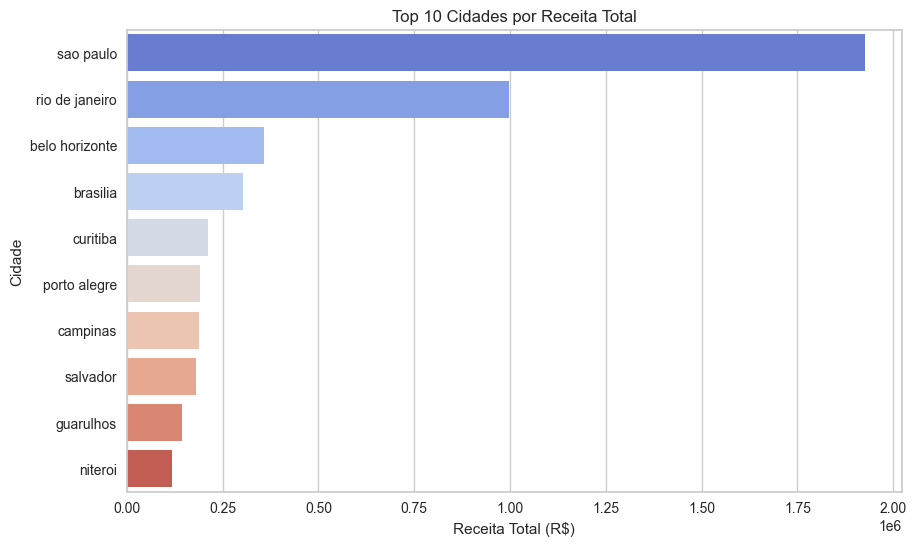

C:\Users\luan\AppData\Local\Temp\ipykernel_12632\2719456111.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_quantity', y='customer_city', data=city_sales_sorted, palette='Purples')


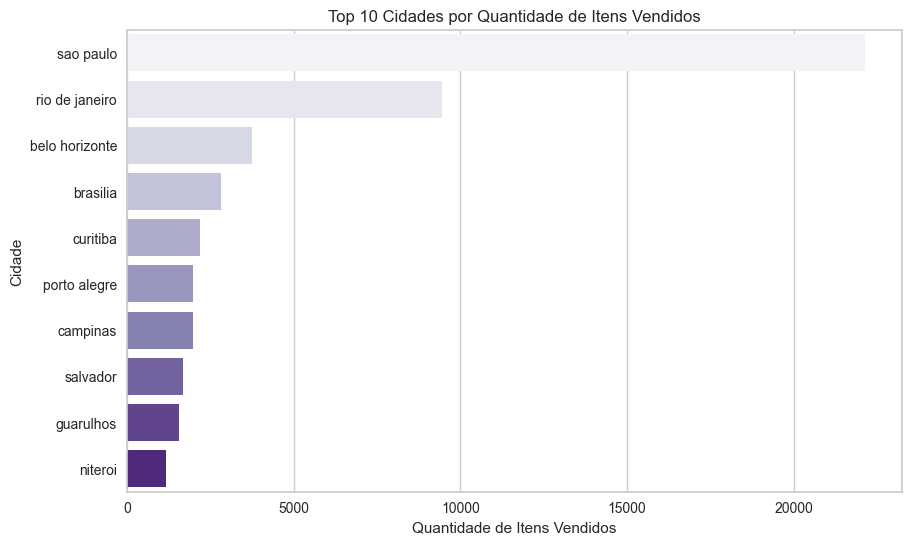

In [28]:
# Agrupando por cidade e somando a quantidade e a receita
city_sales = merged.groupby(['customer_state', 'customer_city']).agg(
    total_revenue=('price', 'sum'),
    total_quantity=('qtd_item', 'sum')).reset_index()

# Ordenando por maior receita e filtrando as 10 primeiras cidades
city_sales_sorted = city_sales.sort_values(ascending=False, by='total_revenue').head(10)

# Plotando gráfico de barras para receita
plt.figure(figsize=(10, 6))
sns.barplot(x='total_revenue', y='customer_city', data=city_sales_sorted, palette='coolwarm')
plt.title('Top 10 Cidades por Receita Total')
plt.xlabel('Receita Total (R$)')
plt.ylabel('Cidade')
plt.show()

# Plotando gráfico de barras para quantidade
plt.figure(figsize=(10, 6))
sns.barplot(x='total_quantity', y='customer_city', data=city_sales_sorted, palette='Purples')
plt.title('Top 10 Cidades por Quantidade de Itens Vendidos')
plt.xlabel('Quantidade de Itens Vendidos')
plt.ylabel('Cidade')
plt.show()


### **Top 10 de Pedidos por Cidade (Valor Total e Quantidade de Itens)**

Nesta análise, calculei a receita total e a quantidade de itens vendidos nas 10 principais cidades. O objetivo foi identificar as cidades que mais contribuíram para as vendas, tanto em volume quanto em receita gerada.

 **Conclusões:**
- **São Paulo (SP)** destaca-se com a maior receita total de R$ 1.925.985,54 e a maior quantidade de itens vendidos (17.933). As cidades de **Campinas**, **Guarulhos** e **São Bernardo do Campo** também contribuem significativamente para as vendas no estado.
  
- **Rio de Janeiro (RJ)** ocupa a segunda posição com R$ 997.535,38 em vendas e 7.887 itens vendidos.

- Outras cidades como **Belo Horizonte (MG)** e **Brasília (DF)** aparecem na lista, com receitas abaixo de R$ 400.000,00.

Esses dados podem ser úteis para adaptar estratégias regionais de vendas, promovendo maior foco nas cidades com maior volume de vendas e otimizando o estoque conforme a demanda local.


In [30]:
# Top 20 vendas das categorias de produtos por Cidade (quantidade)
categoria_produtos_cidade = merged.groupby(["customer_state", "customer_city", "product_category_name"]).agg({"price":"sum", "qtd_item":"count"})
categoria_produtos_cidade = categoria_produtos_cidade.sort_values(ascending=False, by="qtd_item")[:20].reset_index()
categoria_produtos_cidade

,customer_state,customer_city,product_category_name,price,qtd_item
0,SP,sao paulo,cama_mesa_banho,173717.08,2028
1,SP,sao paulo,beleza_saude,189591.66,1756
2,SP,sao paulo,esporte_lazer,145790.32,1413
3,SP,sao paulo,utilidades_domesticas,105028.35,1327
4,SP,sao paulo,moveis_decoracao,100612.54,1274
5,SP,sao paulo,informatica_acessorios,145527.35,1234
6,RJ,rio de janeiro,cama_mesa_banho,78557.86,859
7,SP,sao paulo,relogios_presentes,166536.45,846
8,SP,sao paulo,brinquedos,69845.69,660
9,RJ,rio de janeiro,moveis_decoracao,56317.82,621


### **Top 10 de Pedidos por Cidade, Estado e Categoria de Produto (Valor Total e Quantidade de Itens)**

Nesta análise, calculei o valor total das vendas e a quantidade de itens vendidos, segmentados por cidade, estado e categoria de produto. O objetivo é entender melhor como as diferentes categorias de produtos performam em diversas localidades.

**Conclusões:**
- **São Paulo (SP)** se destaca fortemente, com a maior parte das categorias de produto entre as mais vendidas. As categorias mais lucrativas em São Paulo incluem **Beleza e Saúde**,

- **Cama, Mesa e Banho** e **Esporte e Lazer**, com valores totais de vendas que chegam a R$ 189.591,66, R$ 173.717,08 e R$ 145.790,32, respectivamente.

- **Rio de Janeiro (RJ)** também aparece com vendas expressivas, especialmente em **Cama, Mesa e Banho** (R$ 78.557,86) e **Esporte e Lazer** (R$ 71.434,46), mas com valores totais de vendas inferiores em comparação com São Paulo.

- Outras categorias de produtos, como **Móveis e Decoração**, **Telefonia** e **Automotivo**, têm maior performance em São Paulo, com um volume considerável de vendas também em Rio de Janeiro.

Essa análise permite identificar quais categorias têm mais sucesso em determinadas cidades e estados, oferecendo insights valiosos para estratégias de marketing regionalizadas e de estoque.


In [32]:
# Top 10 das melhores avaliações por categoria do produto
avaliacao_categoria = merged.groupby("product_category_name").agg({"review_score":"mean", "price":"mean", "qtd_item":"count"})
avaliacao_categoria = avaliacao_categoria.sort_values(ascending=False, by="review_score")[:10].reset_index()
avaliacao_categoria

,product_category_name,review_score,price,qtd_item
0,cds_dvds_musicais,4.642857,52.142857,14
1,fashion_roupa_infanto_juvenil,4.500000,71.231250,8
2,livros_interesse_geral,4.446266,84.732152,553
3,construcao_ferramentas_ferramentas,4.444444,154.407282,103
4,flores,4.419355,33.637576,33
5,livros_importados,4.400000,77.330833,60
6,livros_tecnicos,4.368421,71.185985,269
7,alimentos_bebidas,4.315412,54.537393,280
8,malas_acessorios,4.315257,128.598883,1092
9,portateis_casa_forno_e_cafe,4.302632,624.285658,76


C:\Users\luan\AppData\Local\Temp\ipykernel_12632\3767545049.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='product_category_name', data=top_categories_price_sorted, palette='viridis')


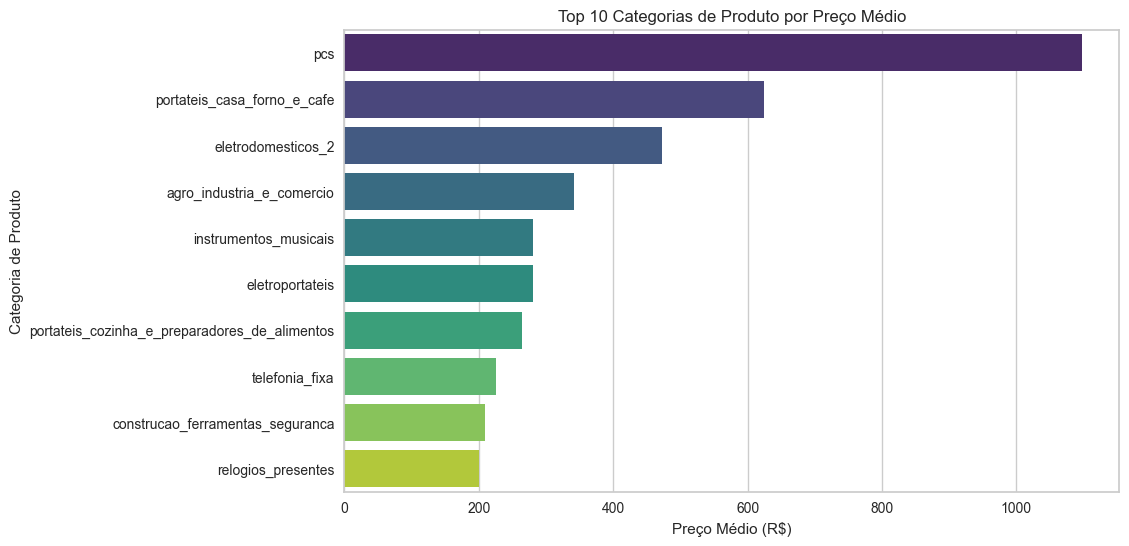

In [33]:
# Agrupando por categoria e calculando o preço médio
top_categories_price = merged.groupby('product_category_name')['price'].mean().reset_index()

# Ordenando em ordem decrescente de preço
top_categories_price_sorted = top_categories_price.sort_values(ascending=False, by='price').head(10)

# Plotando gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='price', y='product_category_name', data=top_categories_price_sorted, palette='viridis')
plt.title('Top 10 Categorias de Produto por Preço Médio')
plt.xlabel('Preço Médio (R$)')
plt.ylabel('Categoria de Produto')
plt.show()


### **Top 10 Categorias de Produtos por Avaliação, Preço e Quantidade de Itens**

Nesta análise, examino as categorias de produtos com base na média das avaliações dos clientes, preço e quantidade de itens vendidos. O objetivo é identificar quais categorias têm o melhor desempenho, considerando a qualidade percebida pelos consumidores e as vendas realizadas.


**Conclusões:**
- A categoria **CDs, DVDs e Musicais** apresenta a melhor média de avaliação (4.64), embora tenha um volume relativamente baixo de vendas (14 unidades).
  
- **Fashion - Roupas Infanto-Juvenil** e **Livros - Interesse Geral** também têm boas avaliações (4.5 e 4.45, respectivamente), com quantidades de itens vendidas de 8 e 553, o que indica uma combinação de alta qualidade e volume de vendas.

- **Livros Técnicos** e **Alimentos e Bebidas** são outras categorias que se destacam com avaliações superiores a 4, com quantidades significativas de vendas, respectivamente 269 e 280 itens.

- **Portáteis de Casa (Forno e Café)** apresenta uma avaliação de 4.30, com um preço relativamente alto (R$ 624,29), mas com uma quantidade de vendas modesta de 76 unidades.

Essa análise permite compreender como a avaliação do cliente se relaciona com as vendas, oferecendo insights sobre categorias que, apesar de preços elevados, podem não ter um volume significativo de vendas, e outras que, mesmo com preços mais baixos, têm avaliações muito positivas e boas vendas.


### Selecionando os dados para o modelo

In [36]:
# Agrupando os dados pelo identificador do pedido e nome da categoria, somando o número de itens em cada grupo
order_category_counts = merged.groupby(['order_id', 'product_category_name'])['qtd_item'].sum().reset_index()

# Exibindo as primeiras linhas dos dados agrupados
order_category_counts.head()


,order_id,product_category_name,qtd_item
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,1
1,00018f77f2f0320c557190d7a144bdd3,pet_shop,1
2,000229ec398224ef6ca0657da4fc703e,moveis_decoracao,1
3,00024acbcdf0a6daa1e931b038114c75,perfumaria,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ferramentas_jardim,1


Agrupei os dados por `order_id` e `product_category_name`, e calculei a soma da quantidade de itens (`qtd_item`) para cada combinação.

In [38]:
# Resetando o indice
order_category_counts = order_category_counts.reset_index()
order_category_counts

,index,order_id,product_category_name,qtd_item
0,0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,1
1,1,00018f77f2f0320c557190d7a144bdd3,pet_shop,1
2,2,000229ec398224ef6ca0657da4fc703e,moveis_decoracao,1
3,3,00024acbcdf0a6daa1e931b038114c75,perfumaria,1
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,ferramentas_jardim,1
...,...,...,...,...
98014,98014,fffc94f6ce00a00581880bf54a75a037,utilidades_domesticas,1
98015,98015,fffcd46ef2263f404302a634eb57f7eb,informatica_acessorios,1
98016,98016,fffce4705a9662cd70adb13d4a31832d,esporte_lazer,1
98017,98017,fffe18544ffabc95dfada21779c9644f,informatica_acessorios,1


Neste trecho, o índice do DataFrame order_category_counts é resetado com o método reset_index(). O argumento drop=True é utilizado para evitar a criação de uma coluna extra com o índice antigo, e o inplace=True garante que a alteração seja feita diretamente no DataFrame

In [40]:
# Agrupando os dados pelo identificador do pedido e diversas outras colunas, somando o número de itens em cada grupo
order_full = merged.groupby(
    ['order_id', 'product_category_name', 'customer_id', 'order_status', 'order_purchase_timestamp',
     'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
     'order_estimated_delivery_date', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 
     'freight_value', 'customer_unique_id', 'customer_city', 'customer_state']
)['qtd_item'].sum().reset_index()


order_full.head()


,order_id,product_category_name,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_city,customer_state,qtd_item
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,1
1,00018f77f2f0320c557190d7a144bdd3,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,SP,1
2,000229ec398224ef6ca0657da4fc703e,moveis_decoracao,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,3818d81c6709e39d06b2738a8d3a2474,para de minas,MG,1
3,00024acbcdf0a6daa1e931b038114c75,perfumaria,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,af861d436cfc08b2c2ddefd0ba074622,atibaia,SP,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ferramentas_jardim,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,SP,1


In [41]:
order_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98780 entries, 0 to 98779
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98780 non-null  object        
 1   product_category_name          98780 non-null  object        
 2   customer_id                    98780 non-null  object        
 3   order_status                   98780 non-null  object        
 4   order_purchase_timestamp       98780 non-null  object        
 5   order_approved_at              98780 non-null  datetime64[ns]
 6   order_delivered_carrier_date   98780 non-null  datetime64[ns]
 7   order_delivered_customer_date  98780 non-null  datetime64[ns]
 8   order_estimated_delivery_date  98780 non-null  datetime64[ns]
 9   product_id                     98780 non-null  object        
 10  seller_id                      98780 non-null  object        
 11  shipping_limit_

Aqui eu agrupei os dados por várias colunas-chave, como o identificador do pedido, categoria de produto e informações sobre o cliente e status do pedido. A função sum() foi usada para somar as quantidades de itens (qtd_item) em cada grupo. O reset_index() é aplicado para garantir que o índice do DataFrame seja sequencial após a agregação.

In [43]:
# Resetando o índice para garantir que o DataFrame tenha um índice sequencial após o agrupamento
order_full = order_full.reset_index()

# Exibindo as primeiras linhas do DataFrame com o índice resetado
order_full.head()

,index,order_id,product_category_name,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_city,customer_state,qtd_item
0,0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,1
1,1,00018f77f2f0320c557190d7a144bdd3,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,SP,1
2,2,000229ec398224ef6ca0657da4fc703e,moveis_decoracao,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,3818d81c6709e39d06b2738a8d3a2474,para de minas,MG,1
3,3,00024acbcdf0a6daa1e931b038114c75,perfumaria,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,af861d436cfc08b2c2ddefd0ba074622,atibaia,SP,1
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,ferramentas_jardim,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,SP,1


Resetei o índice do DataFrame order_full após o agrupamento.Fiz isso para garantir que o DataFrame tenha um índice sequencial e não mantenha os índices antigos das colunas agrupadas. Creio ser uma escolha útil para evitar problemas com a estrutura do DataFrame, especialmente ao trabalhar com dados agregados.

In [45]:
base_treinamento = order_full

In [46]:
base_treinamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98780 entries, 0 to 98779
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          98780 non-null  int64         
 1   order_id                       98780 non-null  object        
 2   product_category_name          98780 non-null  object        
 3   customer_id                    98780 non-null  object        
 4   order_status                   98780 non-null  object        
 5   order_purchase_timestamp       98780 non-null  object        
 6   order_approved_at              98780 non-null  datetime64[ns]
 7   order_delivered_carrier_date   98780 non-null  datetime64[ns]
 8   order_delivered_customer_date  98780 non-null  datetime64[ns]
 9   order_estimated_delivery_date  98780 non-null  datetime64[ns]
 10  product_id                     98780 non-null  object        
 11  seller_id      

In [47]:
# Verificando se existe valores NULL
base_treinamento.isna().sum()

index                            0
order_id                         0
product_category_name            0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
qtd_item                         0
dtype: int64

1. Agrupei os dados por múltiplos atributos, como `order_id`, `product_category_name`, e outras colunas relacionadas ao pedido e cliente, contando o número de itens em cada grupo. Em seguida, redefini o índice para garantir que a tabela estivesse pronta para análise.
   
2. Criei uma base de treinamento (`base_treinamento`) com os dados agrupados e organizados. 

3. Por fim, usei o método `info()` para inspecionar o DataFrame final (`order_full`), verificando o tipo de dados, a quantidade de entradas não nulas e o uso de memória, confirmando que todos os dados estão completos e prontos para serem utilizados em modelos de machine learning.

In [49]:
# Apagando as colunas que não são relevantes para o modelo
base_treinamento.drop(columns=["order_id", "customer_id", 
                               "order_status", "order_approved_at",
                               "order_delivered_carrier_date", "order_delivered_customer_date",
                               "order_estimated_delivery_date", "product_id",
                               "seller_id", "shipping_limit_date",
                               "customer_unique_id"
                               ], axis=1, inplace=True)

In [50]:
base_treinamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98780 entries, 0 to 98779
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     98780 non-null  int64  
 1   product_category_name     98780 non-null  object 
 2   order_purchase_timestamp  98780 non-null  object 
 3   price                     98780 non-null  float64
 4   freight_value             98780 non-null  float64
 5   customer_city             98780 non-null  object 
 6   customer_state            98780 non-null  object 
 7   qtd_item                  98780 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.0+ MB


In [51]:
# Agrupando os dados das vendas por data da compra
base_treinamento = base_treinamento.groupby(["order_purchase_timestamp", "product_category_name"]).sum()

In [52]:
# Checando se existe valores nulos
base_treinamento.isna().sum()

index             0
price             0
freight_value     0
customer_city     0
customer_state    0
qtd_item          0
dtype: int64

1. **Criação da lista de colunas não numéricas**: Eu selecionei as colunas 'customer_city' e 'customer_state', pois elas contêm dados textuais que precisam ser convertidos em números para o modelo.

2. **Verificação e conversão**: Para cada coluna na lista, o código verifica se a coluna existe no DataFrame. Se existir, a função `pd.factorize()` é aplicada para transformar os valores em números únicos.

3. **Verificação do DataFrame**: Depois, o código chama o método `.info()` para verificar se as colunas foram realmente convertidas em valores numéricos e para conferir o tipo de dados atual do DataFrame.

In [54]:
base_treinamento.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18326 entries, (datetime.date(2016, 9, 15), 'beleza_saude') to (datetime.date(2018, 8, 29), 'relogios_presentes')
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           18326 non-null  int64  
 1   price           18326 non-null  float64
 2   freight_value   18326 non-null  float64
 3   customer_city   18326 non-null  object 
 4   customer_state  18326 non-null  object 
 5   qtd_item        18326 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 918.2+ KB


O DataFrame atual possui 98.780 entradas e 8 colunas. Dentre essas colunas, temos:

- **Índice**: Identificador único para cada linha.
- **product_category_name**: Nome da categoria do produto (ainda como tipo `object`, texto).
- **order_purchase_timestamp**: Data da compra (tipo `object`, precisa ser convertida para `datetime`).
- **price**: Preço do produto (tipo `float64`).
- **freight_value**: Valor do frete (tipo `float64`).
- **customer_city**: Cidade do cliente (tipo `object`, texto).
- **customer_state**: Estado do cliente (tipo `object`, texto).
- **qtd_item**: Quantidade de itens do pedido (tipo `int64`).

As colunas 'product_category_name', 'customer_city' e 'customer_state' ainda são do tipo `object` (texto), e é necessário convertê-las para valores numéricos ou categóricos para o modelo. 


In [56]:
non_numeric_cols = ['customer_city', 'customer_state']
# Converter essas colunas para valores numéricos usando pd.factorize()
for col in non_numeric_cols:
    if col in base_treinamento.columns:  # Verifica se a coluna existe
        base_treinamento[col] = pd.factorize(base_treinamento[col])[0]

base_treinamento.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18326 entries, (datetime.date(2016, 9, 15), 'beleza_saude') to (datetime.date(2018, 8, 29), 'relogios_presentes')
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           18326 non-null  int64  
 1   price           18326 non-null  float64
 2   freight_value   18326 non-null  float64
 3   customer_city   18326 non-null  int64  
 4   customer_state  18326 non-null  int64  
 5   qtd_item        18326 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 918.2+ KB


Neste trecho de código, estamos convertendo as colunas `customer_city` e `customer_state`, que contém valores de texto, para valores numéricos. Utilizamos a função `pd.factorize()`, que atribui um número único a cada valor distinto nessas colunas, facilitando o uso desses dados em modelos de machine learning. Após a conversão, o método `base_treinamento.info()` é chamado para verificar o status do DataFrame, confirmando que a transformação foi feita corretamente e que todas as colunas estão prontas para o próximo passo do processo de modelagem.


In [58]:
base_treinamento.head()

index   price  freight_value  \
order_purchase_timestamp product_category_name                                  
2016-09-15               beleza_saude            73948   44.99           2.83   
2016-10-03               brinquedos              67138  128.90          25.67   
                         esporte_lazer          175631   79.89          48.54   
                         fashion_calcados        79230   29.99          10.96   
                         moveis_decoracao       173482  194.80          30.93   

                                                customer_city  customer_state  \
order_purchase_timestamp product_category_name                                  
2016-09-15               beleza_saude                       0               0   
2016-10-03               brinquedos                         1               1   
                         esporte_lazer                      2               2   
                         fashion_calcados                   3               0   
                         moveis_decoracao                   4               3   

                                                qtd_item  
order_purchase_timestamp product_category_name            
2016-09-15               beleza_saude                  6  
2016-10-03               brinquedos                    1  
                         esporte_lazer                 3  
                         fashion_calcados              1  
                         moveis_decoracao              2

In [59]:
base_treinamento.describe()

,index,price,freight_value,customer_city,customer_state,qtd_item
count,1.832600e+04,18326.000000,18326.000000,18326.00000,18326.000000,18326.000000
mean,2.662171e+05,667.649798,108.365465,5020.20812,2169.222798,7.151970
std,3.278460e+05,910.331292,130.757610,4232.56770,2698.686877,10.504854
min,9.000000e+00,3.850000,0.000000,0.00000,0.000000,1.000000
25%,6.477525e+04,113.900000,24.190000,794.25000,21.000000,1.000000
50%,1.441220e+05,329.320000,60.150000,4361.50000,567.000000,3.000000
75%,3.533238e+05,858.985000,142.427500,8687.75000,4130.750000,9.000000
max,9.450690e+06,17456.420000,3198.670000,13217.00000,8616.000000,313.000000


In [60]:
base_treinamento.head()

index   price  freight_value  \
order_purchase_timestamp product_category_name                                  
2016-09-15               beleza_saude            73948   44.99           2.83   
2016-10-03               brinquedos              67138  128.90          25.67   
                         esporte_lazer          175631   79.89          48.54   
                         fashion_calcados        79230   29.99          10.96   
                         moveis_decoracao       173482  194.80          30.93   

                                                customer_city  customer_state  \
order_purchase_timestamp product_category_name                                  
2016-09-15               beleza_saude                       0               0   
2016-10-03               brinquedos                         1               1   
                         esporte_lazer                      2               2   
                         fashion_calcados                   3               0   
                         moveis_decoracao                   4               3   

                                                qtd_item  
order_purchase_timestamp product_category_name            
2016-09-15               beleza_saude                  6  
2016-10-03               brinquedos                    1  
                         esporte_lazer                 3  
                         fashion_calcados              1  
                         moveis_decoracao              2

In [61]:
base_treinamento.shape

(18326, 6)

In [62]:
base_treinamento.keys()

Index(['index', 'price', 'freight_value', 'customer_city', 'customer_state',
       'qtd_item'],
      dtype='object')

In [63]:
# análise de correlação
correlation = base_treinamento.corr()

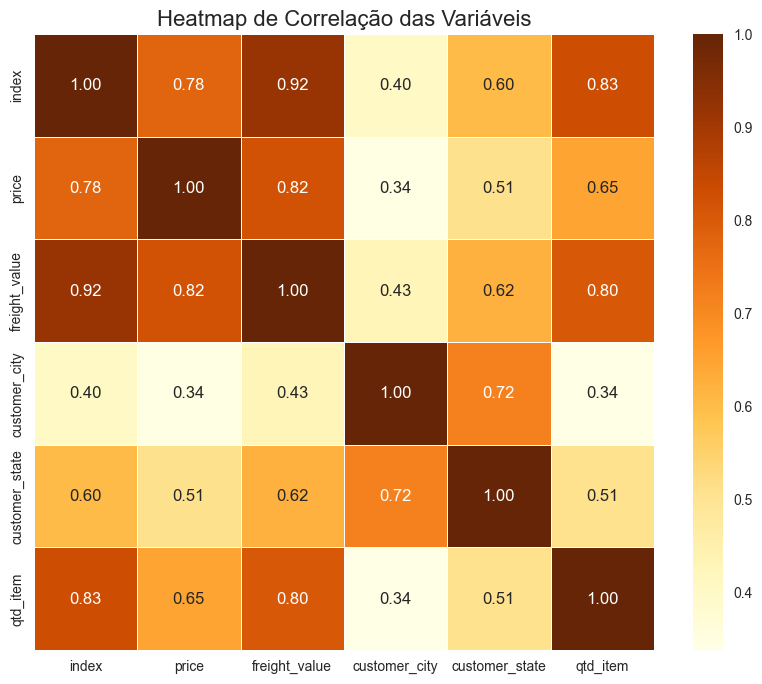

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurando o tamanho do gráfico
plt.figure(figsize=(10, 8))

# Criando o heatmap
sns.heatmap(correlation, annot=True, cmap="YlOrBr", fmt=".2f", linewidths=0.5)

# Adicionando título
plt.title("Heatmap de Correlação das Variáveis", fontsize=16)

# Exibindo o gráfico
plt.show()


### Pré processamento dos modelos

In [66]:
# Selecionar todas as colunas exceto a classe (qtd_item)
X_dict = base_treinamento.drop(columns=['qtd_item']).T.to_dict().values()

# Transformar as variáveis categóricas em vetores numéricos
vect = DictVectorizer(sparse=False)
X = vect.fit_transform(X_dict)

# Codificar a variável alvo (qtd_item) em valores numéricos
le = LabelEncoder()
y = le.fit_transform(base_treinamento["qtd_item"])

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


1. **Seleção de Variáveis Independentes (X)**:
   - Removi a coluna `qtd_item` do DataFrame e converti as outras colunas em um dicionário para preparar para o vetorizador.

2. **Transformação de Variáveis Categóricas**:
   - Utilizei o `DictVectorizer` para transformar colunas categóricas e numéricas em vetores numéricos.

3. **Codificação da Variável Alvo (y)**:
   - Apliquei o `LabelEncoder` para transformar os valores da coluna `qtd_item` em números inteiros.

4. **Divisão Treino/Teste**:
   - Dividi os dados em 80% para treino e 20% para teste, garantindo a mistura aleatória com `shuffle=True`.

### Testando alguns modelos

Escrevi essa função para avaliar alguns modelos que, com base em minhas pesquisas, acredito que são adequados para resolver o problema. Escolhi modelos comumente utilizados para prever valores numéricos contínuos ao longo de um determinado período de tempo.

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
import pandas as pd

def evaluate(X_train, X_test, y_train, y_test):
    # Nome dos modelos
    model_name_list = ['Linear Regression',
                       'Random Forest Regressor',
                       'XGBRegressor',
                       'Gradient Boosting Regressor',
                       'KNeighbors Regressor']

    # Instanciando os modelos
    model1 = LinearRegression()
    model2 = RandomForestRegressor(random_state=1)
    model3 = xgb.XGBRegressor(random_state=0)
    model4 = GradientBoostingRegressor(n_estimators=20, random_state=42)
    model5 = KNeighborsRegressor(n_neighbors=5)

    # Dataframe para os resultados
    results = pd.DataFrame(columns=['r2'], index=model_name_list)

    # Avaliando os modelos
    for i, model in enumerate([model1, model2, model3, model4, model5]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Métrica R²
        r2 = r2_score(y_test, predictions)

        # Resultados
        model_name = model_name_list[i]
        results.loc[model_name, :] = [r2]

    return results

# Chamando a função para avaliar os modelos
results = evaluate(X_train, X_test, y_train, y_test)
results


,r2
Linear Regression,0.733267
Random Forest Regressor,0.772457
XGBRegressor,0.749023
Gradient Boosting Regressor,0.775335
KNeighbors Regressor,0.735145


Aqui estão os resultados dos modelos que testei para prever os valores do nosso conjunto de dados. A métrica que usamos foi o **R²**, que basicamente mostra o quanto do comportamento dos dados o modelo consegue explicar. Quanto mais perto de 1, melhor.

**Análise:**
1. O **Gradient Boosting Regressor** foi o que obteve o melhor desempenho, com um **R² de 0.775**. Isso significa que ele conseguiu explicar mais da variabilidade dos dados do que os outros modelos.
2. O **Random Forest Regressor** também foi muito bem, com **R² de 0.772**. A diferença entre ele e o Gradient Boosting foi pequena.
3. O **XGBRegressor** ficou um pouco atrás com **R² de 0.749**, mas ainda assim é um bom modelo.
4. A **Linear Regression** e o **KNeighbors Regressor** tiveram um desempenho mais baixo, com **R² de 0.733** e **0.735**, respectivamente. Eles ainda podem ser úteis dependendo do contexto, mas não são os melhores para esse problema específico.

Com isso, eu considero que o **Gradient Boosting Regressor** ou o **Random Forest Regressor** são as melhores opções para esse problema. Ambos têm um desempenho bem próximo, e posso decidir entre eles dependendo de outros fatores como tempo de treinamento e a necessidade de interpretar o modelo de forma mais clara.

Se eu quiser melhorar ainda mais, posso tentar ajustar alguns parâmetros de cada modelo (como o número de árvores no Random Forest ou os parâmetros de aprendizado no XGBoost).

### Modelo Linear Regression

In [73]:
# Treinar o modelo Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [74]:
linear_model.predict(X_train)

array([-0.05935566,  2.77772839,  0.88772636, ...,  2.06423088,
        0.72395413,  6.51577092])

In [75]:
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(linear_model.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(linear_model.score(X_test, y_test)))

Coeficiente R^2 na base de treinamento: 0.77
Coeficiente R^2 na base de teste: 0.73


In [76]:
qtd_preds = linear_model.predict(X_test)
print("MAE: {}".format(mean_absolute_error(y_test, qtd_preds)))
print("MSE: {}".format(mean_squared_error(y_test, qtd_preds)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, qtd_preds))))

MAE: 2.0743945211040393
MSE: 22.831757602525094
RMSE: 4.7782588463293925


### Análise do Modelo Linear Regression

Treinei o modelo **Linear Regression** e fiz algumas análises de desempenho tanto na base de treinamento quanto na base de teste.

** Coeficiente R²: **
- **Base de Treinamento**: O modelo obteve um **R² de 0.77**, o que significa que ele conseguiu explicar 77% da variação dos dados de treinamento.
- **Base de Teste**: O **R² na base de teste foi de 0.73**, o que é um bom resultado, embora o modelo tenha mostrado um leve decréscimo de desempenho ao ser testado com novos dados.

#### Erros:
- **MAE (Erro Absoluto Médio)**: 2.07 — Isso significa que, em média, o modelo errou por cerca de 2 unidades no valor da previsão.
- **MSE (Erro Quadrático Médio)**: 22.83 — O MSE penaliza mais os grandes erros, o que pode indicar que, ocasionalmente, o modelo cometeu previsões muito distantes do valor real.
- **RMSE (Raiz do Erro Quadrático Médio)**: 4.78 — A raiz quadrada do MSE, que também é uma métrica para mostrar o erro médio, em termos das mesmas unidades da variável de previsão.

### Conclusão:
O **Linear Regression** apresentou um bom desempenho, especialmente considerando que é um modelo simples. Ele consegue capturar uma boa parte da variação dos dados, mas ainda existe espaço para melhorias. O modelo não teve grandes diferenças entre o treinamento e o teste, o que é bom, pois indica que não houve overfitting.

Se eu precisar de um modelo mais preciso, posso tentar ajustar hiperparâmetros ou testar outros modelos mais complexos, como o **Random Forest** ou o **Gradient Boosting Regressor**, que mostraram melhores resultados nas análises anteriores.

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Instanciando o modelo Gradient Boosting Regressor
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Treinando o modelo
gradient_boosting_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de treino
train_preds = gradient_boosting_model.predict(X_train)
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(gradient_boosting_model.score(X_train, y_train)))

# Fazendo previsões no conjunto de teste
test_preds = gradient_boosting_model.predict(X_test)
print("Coeficiente R^2 na base de teste: {:.2f}".format(gradient_boosting_model.score(X_test, y_test)))

# Avaliando o desempenho com diferentes métricas
mae = mean_absolute_error(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
rmse = np.sqrt(mse)

print("MAE: {}".format(mae))
print("MSE: {}".format(mse))
print("RMSE: {}".format(rmse))


Coeficiente R^2 na base de treinamento: 0.80
Coeficiente R^2 na base de teste: 0.79
MAE: 1.9912562824049576
MSE: 17.853317360244983
RMSE: 4.225318610500867


1. **Instanciação do Modelo**: O `GradientBoostingRegressor` é instanciado com 100 estimadores (árvores), que pode ser ajustado pelo número de árvores com o parâmetro `n_estimators`. O `random_state=42` garante a reprodutibilidade dos resultados.

2. **Treinamento**: O modelo é treinado utilizando o conjunto de treino, com `fit(X_train, y_train)`.

3. **Previsões**: O modelo faz previsões tanto no conjunto de treinamento quanto no conjunto de teste.

4. **Avaliação de Desempenho**:
    - **Coeficiente R²**: Mostra o quão bem o modelo está explicando a variação dos dados.
    - **MAE (Erro Absoluto Médio)**: Média dos erros absolutos entre as previsões e os valores reais.
    - **MSE (Erro Quadrático Médio)**: Penaliza erros grandes ao elevar ao quadrado as diferenças entre as previsões e os valores reais.
    - **RMSE (Raiz do Erro Quadrático Médio)**: A raiz quadrada do MSE, que coloca o erro em unidades mais próximas da variável alvo.

### Ideias de Ajustes:
- **n_estimators**: O número de árvores do modelo. Mais árvores podem aumentar a complexidade do modelo.
- **learning_rate**: Controla a contribuição de cada árvore para o modelo final. Um valor menor pode melhorar a generalização, mas pode exigir mais árvores.
- **max_depth**: Define a profundidade máxima das árvores. Árvores mais rasas podem evitar o overfitting.

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

# Definindo o modelo com os parâmetros ajustados
gradient_boosting_model = GradientBoostingRegressor(
    n_estimators=100,           # Número de árvores (quanto maior, mais complexo o modelo)
    learning_rate=0.05,         # Taxa de aprendizado (valor escolhido para balancear entre acurácia e complexidade)
    max_depth=3,                # Profundidade máxima das árvores (limitando para evitar overfitting)
    random_state=42             # Para garantir reprodutibilidade
)

# Treinando o modelo
gradient_boosting_model.fit(X_train, y_train)

# Prevendo na base de teste
y_pred = gradient_boosting_model.predict(X_test)

# Avaliando o modelo
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(gradient_boosting_model.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(gradient_boosting_model.score(X_test, y_test)))

# Calculando as métricas de erro
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))


Coeficiente R^2 na base de treinamento: 0.79
Coeficiente R^2 na base de teste: 0.79
MAE: 2.001115430171605
MSE: 17.666226180680532
RMSE: 4.203121004763071


Os resultados indicam que o **Gradient Boosting Regressor** com os ajustes realizados (100 árvores, learning rate de 0.05 e profundidade máxima de 3) teve um bom desempenho tanto na base de treinamento quanto na base de teste:

- **Coeficiente R² na base de treinamento: 0.79** e **na base de teste: 0.79**: Isso significa que o modelo é capaz de explicar 79% da variação nas quantidades de itens vendidos, tanto nos dados de treinamento quanto nos dados de teste, o que é um bom indicativo de que o modelo está generalizando bem.
  
- **MAE (Erro Absoluto Médio): 2.00**: O erro médio absoluto é razoavelmente baixo, indicando que, em média, as previsões do modelo estão próximas dos valores reais.

- **MSE (Erro Quadrático Médio): 17.67** e **RMSE (Raiz do Erro Quadrático Médio): 4.20**: Esses valores confirmam que o modelo está realizando previsões bastante precisas, com um erro razoável.

Em resumo, o modelo Gradient Boosting Regressor com esses parâmetros tem se mostrado eficaz para prever as quantidades de itens vendidos por categoria de produto no e-commerce brasileiro, equilibrando bem a complexidade e a acurácia, sem overfitting.

### Conclusões

Após testar diferentes modelos, a análise dos resultados nos mostrou que o **Gradient Boosting Regressor** foi o modelo que apresentou o melhor desempenho para prever as quantidades de itens vendidos por categoria de produto no e-commerce brasileiro.

- O **Gradient Boosting Regressor** obteve um **coeficiente R² de 0.79** tanto na base de treinamento quanto na base de teste, o que indica uma boa capacidade de generalização e precisão nas previsões.
- Além disso, os **erros absolutos médios (MAE)** e quadráticos (MSE, RMSE) foram baixos, sugerindo que o modelo faz previsões bastante próximas dos valores reais.

Comparado aos outros modelos testados, como a **Regressão Linear**, **Random Forest**, e **XGBRegressor**, o Gradient Boosting se destacou por sua performance consistente e eficaz, apresentando uma combinação ideal entre precisão e capacidade de evitar overfitting. A robustez desse modelo, especialmente ao ajustar parâmetros como o número de estimadores (100), a taxa de aprendizado (0.05) e a profundidade máxima (3), trouxe resultados equilibrados, sem grandes variações entre o treinamento e o teste.

Portanto, o **Gradient Boosting Regressor** foi o modelo mais eficaz para a tarefa de prever as quantidades de itens vendidos, atendendo ao objetivo inicial de previsão para um e-commerce brasileiro.